# Versuch 11
## Gasthermometer
Zu Beginn werden alle für die Auswertung notwendigen Module importiert. Welche Module könntet ihr wie üblich für die Auswertung brauchen? Die allgemeinen bereits bekannten und vorausgetzten Python-Kompetenzen könnt ihr unter [Anforderungen.ipynb](Anforderungen.ipynb) nachlesen. Dort sind auch einige Ratschläge bspw. zum Exportieren von Grafiken oder Hinweise zu <code>NumPy</code> aufgeführt.

Falls euch nachträglich Module einfallen, könnt ihr diese jederzeit hier ergänzen. Achtet dabei aber darauf, den entsprechenden Code dann auch erneut auszuführen!

In [1]:
from Hilfsdateien.importe_Bibliotheken import *

Wenn ihr wollt, könnt ihr auch einige für die Auswertung notwendige Naturkonstanten bereits jetzt importieren von <code>scipy.constants</code>. Bedenkt, dass ihr diese Variablennamen nicht erneut nutzen solltet in der Auswertung! 

Sinnvoll wäre z. B. die universelle Gaskonstante $R$ oder der Konvertierungsfaktor von Torr in Pascal. Achtet wenn notwendig auf die Einheiten!

In [2]:
from Hilfsdateien.importe_Konstanten import *

## Erster Auswertungsschritt
Zu Beginn wollen wir unseren Datensatz in ein 3D-Array mit einlesen. <code>numpy</code> einlesen. Welchen Befehl solltet ihr hierfür nutzen? Die Daten sind in vier verschiedenen Dateien (Argon, Helium, Kohlenstoffdioxid, Stickstoff) aufgeteilt, aber auch das Einlesen aus einer großen in Spalten unterteilten Datei ist möglich. Nachfolgend wird von vier verschiedenen Dateien ausgegangen!

Wir wollen alle Daten in ein großes 3D-Array einlesen, welches aus $n$ Messreihen mit $j$ Messwerten und $k$ Messgrößen besteht. Entsprechend erstellen wir zunächst ein leeres Numpy-Array mit den entsprechenden Dimensionen.

In [3]:
n,j,k = 4,5,2
gas_arr = np.empty((n,j,k))

Mittels <code>enumerate</code> kann sowohl ein Index als auch der Wert eines Elements in einem Array übertragen werden. Die erste Variable ist immer der Index und die Zweite der Eintrag im Array. Wir wollen enumerate über ein Array laufen lassen, welches die Pfade zu unseren Messwerten enthält, welchen wir brauchen, um die Werte aus den Dateien einzulesen. Mit welchem Numpy-Befehl _generieren_ wir in Python aus z.B. txt-Dateien (aber natürlich auch aus csv, dat,…) Arrays?

Die Messwerte bei einem Index $i$ können dem $i$-ten Element in unserem 3D-Array zugewiesen werden, sodass alle Messreihen in einem großen Array gespeichert sind.

In [4]:
ddir = "data_v10/"
for index,messung in enumerate(["argon.csv","helium.csv","kohlenstoffdioxid.csv","stickstoff.csv"]):
    gas_arr[index] = np.genfromtxt(ddir+messung,usecols=(0,1),skip_header=2,delimiter=",")

Nun können wir aus unseren Daten die Proportionalitätskonstante $a$ ermitteln. Zur Auswertung brauchen wir die Siedetemperatur von Wasser unter den Messbedingungen. Diese müsst ihr nun nachfolgend bestimmen.

Dies geht beispielsweise durch Umformen von der Clausius-Clapeyron-Gleichung
\begin{align}
\frac{\mathrm{d}\ln\left(\frac{p}{p^{⦵}}\right)}{\mathrm{d}\frac{1}{T}} - \frac{-\Delta_\mathrm{v}H}{R}= 0
\end{align}
anhand von Literaturwerten von $\Delta_\mathrm{v}H$. Um potentielle Fehler beim Umformen zu vermeiden ist es sinnvoll, die Umformung durch <code>sympy</code> erledigen zu lassen. Hierzu definieren wir zunächst den linken Term der obigen Gleichung als eine Funktion in SymPy. Deren Funktionsvariablen müssen zunächst als „Symbole“ definiert werden, damit SymPy diese als Variablen einer Funktion $f(a,b,c,\dots)$ interpretiert. Im Anschluss kann mit diesen Variablen $a,b,c,\dots$ ein Ausdruck erstellt werden.

In [5]:
MESSWERT = 744.0
p_labor = torr_Pa * MESSWERT
#print(p_labor)
H_wasser = 40651.0 #J/(mol K), P. Atkins, 4, Aufl. 2005.
H,pLab,dpLab,pAqu,dpAqu,Ts = symbols('H pLab dpLab pAqu dpAqu Ts')
expr = -H/R  - (log(pAqu)-log(pLab))/(1/(273.15+100) - 1/(Ts))

Dieser Ausdruck ist offensichtlich nicht nach der Siedetemperatur umgestellt. Man kann den Ausdruck auch als eine zu lösende Gleichung betrachten, wir sind an der Lösung nach der Siedetemperatur $T_\mathrm{S}$ interessiert. Mit welchem Befehl können wir Gleichungen lösen? Macht dies nun!

In [6]:
T_s = solve(expr,Ts)[0]

Wir sind auch an der Unsicherheit von $T_\mathrm{S}$ interessiert. Folglich soll SymPy uns die notwendigen Ableitungen bestimmen. Wie könnt ihr dies mittels SymPy erledigen?

In [7]:
dT_s = sqrt((diff(T_s,pLab)*dpLab)**2)

Nachdem die Ausdrücke definiert haben, müssen diese mittels eines weiteren SymPy-Befehls in aufrufbare Funktionen überführt werden (GIYF, eine [anonyme Funktion](https://de.wikipedia.org/wiki/Anonyme_Funktion) wird oftmals lambda-Funktion genannt!). An diese Funktion können wir dann die Messwerte übergeben und erhalten $T_\mathrm{S}$ als Ergebnis.

In [8]:
T_s = lambdify([H,pLab,pAqu],T_s,'scipy')
dT_s = lambdify([H,pLab,dpLab,pAqu,dpAqu],dT_s,'scipy')

T_siede = T_s(H_wasser,p_labor,101325.0)
dT_siede = dT_s(H_wasser,p_labor, 0.05*torr_Pa,101325.0,0)
print(T_siede, dT_siede)

372.54501628858407 0.0019077327544995972


Vermutlich ist die bestimmte Siedetemperatur unter den Messbedingungen ungleich der Normalsiedetemperatur $T_\mathrm{S,norm}$. Jene solltet ihr im nächsten Schritt, der Bestimmung von _a_ berücksichtigen. Analog zu $T_\mathrm{S}$ wollen wir zur Bestimmung von $a$ SymPy nutzen und dessen Unsicherheit mit Gaußscher Fehlerfortpflanzung ermitteln. _Es ist kein Umformschritt verlangt, $a$ kann direkt als Funktion der Temperaturdifferenz und der Drücke definiert werden!_

In [9]:
pSiede,dpSiede,pSchmelz,dpSchmelz,Tdiff,dTdiff = symbols('pSiede dpSiede pSchmelz dpSchmelz Tdiff dTdiff')
a = Tdiff/(pSiede-pSchmelz)
da = sqrt((diff(a,Tdiff)*dTdiff)**2 + (diff(a,pSiede)*dpSiede)**2 + (diff(a,pSchmelz)*dpSchmelz)**2)

a = lambdify([Tdiff,pSiede,pSchmelz],a,'scipy')
da = lambdify([Tdiff,dTdiff,pSiede,dpSiede,pSchmelz,dpSchmelz],da,'scipy')
#Unter der Annahme, dass der letzt Eintrag der der Siedetemperatur ist
#Im Datensatz ist alles in bar, daher *10**5 für Pascal
#-1 Siedetemperatur
#-2 Flüssiges Wasser
#-3 Eis/Wasser
print(T_siede - 273.15)


99.39501628858409


Idealerweise speichern wir die Ergebnisse für $a$ in einem Array und zwar so, dass der Index für jedes Gas derselbe wie im 3D-Array mit allen Messwerten ist. Erstellt je ein leeres Array $a$ und $\Delta a$ und weist den Indizes die entsprechenden Werte zu!

In [10]:
#Gesamtarray mit allen Werten und Unsicherheiten für a
#0 Argon
#1 Stickstoff
#2 Helium
#3 Kohlenstoffdioxid
a_tot_arr = np.empty([n])
da_tot_arr = np.empty([n])
for counter,gas in enumerate(gas_arr):
        a_tot_arr[counter] = 10**5*np.array([a(T_siede - 273.15,gas[-1,1]*10**5,gas[-3,1]*10**5)])
        da_tot_arr[counter] = 10**5*np.array([da(T_siede - 273.15,dT_siede,gas[-1,1]*10**5,0.05*torr_Pa,gas[-3,1]*10**5,0.05*torr_Pa)])
#print(a_tot_arr) #K/bar

## Zweiter Auswertungsschritt


Nachdem wir nun _a_ für die verschiedenen Gase haben, sollen anhand der Messwerte sowohl die Siedetemperatur $T_\mathrm{Siede}$ als auch die Schmelztemperatur $T_\mathrm{Schmelz}$ von Wasser ermittelt werden. Wie solltet ihr hierfür vorgehen? (Fehlerrechnung nicht vergessen!)

In [11]:
#-1 Siedetemperatur
#-2 Flüssiges Wasser
#-3 Eis/Wasser
#Für Datensatz konstanter bias um etwa +20K 

a_val,da_val,p_val,dp_val = symbols('a da p dp')
T_a = a_val*p_val
dT_a = sqrt((diff(T_a,a_val)*da_val)**2 + (diff(T_a,p_val)*dp_val)**2)
T_a = lambdify([a_val,p_val],T_a,'scipy')
dT_a = lambdify([a_val,da_val,p_val,dp_val],dT_a,'scipy')
T_schmelz_a = np.empty([n,k])
#Gesamtarray mit allen Werten und Unsicherheiten für a
#0 Argon
#1 Stickstoff
#2 Helium
#3 Kohlenstoffdioxid
T_schmelz_a = np.empty([n,k])
T_siede_a = np.empty([n,k])
for i,gas in enumerate(gas_arr):
    T_schmelz_a[i,:] = np.array([T_a(a_tot_arr[i],gas[-3,1]),dT_a(a_tot_arr[i],da_tot_arr[i],gas[-3,1],0.0005)])
    T_siede_a[i,:] = np.array([T_a(a_tot_arr[i],gas[-1,1]),dT_a(a_tot_arr[i],da_tot_arr[i],gas[-1,1],0.0005)])
#T_siede_a = np.array([T_a(a_n2[0],n2[-1,1]*10**5),T_a(a_he[0],he[-1,1]*10**5),T_a(a_co2[0],co2[-1,1]*10**5)])
print("Siedetemperaturen")
label_arr = ["Argon","Stickstoff","Helium","Kohlenstoffdioxid"]
for i in np.arange(n):
    print(label_arr[i])
    print(np.array2string(T_schmelz_a[i,:],separator=" ± ") + " K")

Siedetemperaturen
Argon
[292.739 ±   0.389] K
Stickstoff
[293.42 ±   0.39] K
Helium
[291.795 ±   0.406] K
Kohlenstoffdioxid
[292.792 ±   0.441] K


## Dritter Auswertungsschritt
Die nächste Aufgabe ist es, den thermischen Ausdehnungskoeffizienten $\alpha$ nach der im Praktikumsskript genannten Gleichung
\begin{align}
\alpha = \frac{1}{p_0}\left(\frac{\partial p}{\partial T}\right)
\end{align}
zu bestimmen. Hierzukann sollte lineare Regression verwendet werden, wofür verschiedene Python-Module zur Auswahl stehen. Welches ihr wählt ist euch überlassen! Für $p_0$ wird am besten der experimentelle Wert genommen und wie immer sollte auch die Unsicherheit $\Delta \alpha$ bestimmt werden.

Führt eine lineare Regression durch und erstellt eine Auftragung mit den Messwerten und der Regression. Vergesst nicht die Achsenbeschriftung, Legende, Titel, etc.

Ar
[3.519e-03 ± 2.623e-05]/ K⁻¹
0.0015133040621459455
N$_2$
[3.516e-03 ± 3.422e-05]/ K⁻¹
0.0015154782719622153
He
[3.422e-03 ± 1.172e-05]/ K⁻¹
0.0014063603068871812
CO$_2$
[3.554e-03 ± 3.829e-05]/ K⁻¹
0.0013506502481690568


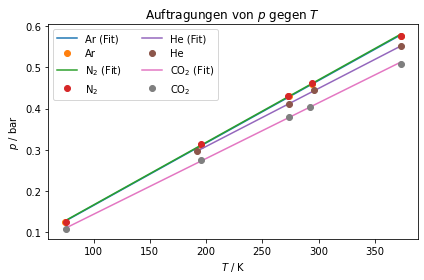

In [12]:
gas_label = ["Ar","N$_2$","He","CO$_2$"]
alpha_arr = np.empty([n,k])
for counter,gas in enumerate(gas_arr):
    #Notwendig, um mit np.nan-Werten umzugehen
    #Im Datensatz waren einige Lücken, die mit np.nan gefüllt wurden
    #Die REALEN Daten der Studenten werden diese Lücken mutmaßlich nicht haben
    #Daher müssen die Studenten vermutlich NICHT die Maskierung nutzen
    mask_x = ~np.isnan(gas[:,0])
    mask_y = ~np.isnan(gas[:,1])
    alpha_plot = linregress(gas[:,0][mask_x],gas[:,1][mask_y])
    plt.plot(gas[:,0],alpha_plot.slope*gas[:,0]+alpha_plot.intercept,'-',label=gas_label[counter]+" (Fit)")
    plt.plot(gas[:,0],gas[:,1],'o',label=gas_label[counter])
    
    
    pzero,dpzero,m,dm = symbols('p0 dp0 m dm')
    alpha = 1/pzero * m
    dalpha = sqrt((diff(alpha,pzero)*dpzero)**2 + (diff(alpha,m)*dm)**2)
    alpha = lambdify([pzero,m],alpha,'scipy')
    dalpha = lambdify([pzero,dpzero,m,dm],dalpha,'scipy')
    print(gas_label[counter])
    alpha_coeff = np.array([alpha(gas[-3,1],alpha_plot.slope),dalpha(gas[-3,1],0.0005,alpha_plot.slope,alpha_plot.stderr)])
    print(np.array2string(alpha_coeff,separator=" ± ")+"/ K⁻¹")
    alpha_arr[counter,:] = alpha_coeff
    print(alpha_plot.slope)
plt.xlabel("$T$ / K")
plt.ylabel("$p$ / bar")
plt.legend(ncol=2)
plt.title("Auftragungen von $p$ gegen $T$")
plt.tight_layout()
plt.show()
plt.close()

## Vierter Auswertungsschritt
Anhand von $\alpha$ soll nun mittels des im Praktikumsskript aufgeführten Gesetz von Gay-Lussac 
\begin{align}
V = V_0 \cdot (1+\alpha\cdot T)
\end{align}
die Raumtemperatur $T_\mathrm{Raum}$ ausgehend vom Volumen $V$ und dem Ursprungsvolumen $V_0$ bestimmt werden. Entsprechend ist es nun eure Aufgabe, wahlweise mittels z.&nbsp;B. SymPy die Gleichung so umzuformen, dass wir die Raumtemperatur bestimmen können. Wie immer sind wir auch an der Unsicherheit $\Delta T_\mathrm{Raum}$ interessiert! Warum ist es kein Problem, dass kein einziges Mal ein Volumen gemessen wurde?

In [13]:
pzero,dpzero,pRT,dpRT,alph,dalph,TRT = symbols('p0 dp0 pRT dpRT alpha dalpha TRT')
T_RT = solve(pzero*(1+alph*TRT) - pRT,TRT)[0]
dT_RT = sqrt((diff(T_RT,pzero)*dpzero)**2 + (diff(T_RT,pRT)*dpRT)**2 + (diff(T_RT,alph)*dalph)**2)
T_RT = lambdify([pzero,alph,pRT],T_RT,'scipy')
dT_RT = lambdify([pzero,dpzero,alph,dalph,pRT,dpRT],dT_RT,'scipy')
for counter,gas in enumerate(gas_arr):
    T_room = T_RT(gas[-3,1],alpha_arr[counter,0],gas[-2,1])
    dT_room = dT_RT(gas[-3,1],0.0005,alpha_arr[counter,0],alpha_arr[counter,1],gas[-2,1],0.0005)
    print(gas_label[counter])
    print(np.array2string(np.array([T_room,dT_room]),separator=" ± ")+" Temperatureinheiten")

Ar
[19.824 ±  0.506] Temperatureinheiten
N$_2$
[20.456 ±  0.523] Temperatureinheiten
He
[23.465 ±  0.529] Temperatureinheiten
CO$_2$
[18.51  ±  0.577] Temperatureinheiten


---
Arved Dorst, Göttingen, __2021__.